## Tests of DR8

Compare DR8 to dr8b.

In [65]:
import os, warnings, pdb
from glob import glob
import numpy as np
#import skimage.io
import fitsio
import matplotlib.pyplot as plt

In [66]:
from astrometry.libkd.spherematch import match_radec
from astropy.table import Table, vstack, Column

In [67]:
plt.style.use('seaborn-talk')
%matplotlib inline

In [76]:
dr8bdir = '/global/project/projectdirs/cosmo/work/legacysurvey/dr8b/decam'
dr8bfiles = np.hstack(glob('{}/tractor/???/tractor-*.fits'.format(dr8bdir)))
dr8bfiles = dr8bfiles[np.argsort(dr8bfiles)]
print(dr8bfiles)

['/global/project/projectdirs/cosmo/work/legacysurvey/dr8b/decam/tractor/000/tractor-0001m002.fits'
 '/global/project/projectdirs/cosmo/work/legacysurvey/dr8b/decam/tractor/000/tractor-0001m005.fits'
 '/global/project/projectdirs/cosmo/work/legacysurvey/dr8b/decam/tractor/000/tractor-0001m007.fits'
 ...
 '/global/project/projectdirs/cosmo/work/legacysurvey/dr8b/decam/tractor/244/tractor-2449p107.fits'
 '/global/project/projectdirs/cosmo/work/legacysurvey/dr8b/decam/tractor/244/tractor-2449p110.fits'
 '/global/project/projectdirs/cosmo/work/legacysurvey/dr8b/decam/tractor/244/tractor-2449p120.fits']


In [77]:
def read_tractor():
    """Read the dr8 and dr8b Tractor catalogs."""
    
    # First read the dr8b catalogs.
    dr8bdir = '/global/project/projectdirs/cosmo/work/legacysurvey/dr8b/decam'
    dr8dir = '/global/project/projectdirs/cosmo/work/legacysurvey/dr8/decam'

    dr8bfiles = glob('{}/tractor/0??/tractor-*.fits'.format(dr8bdir))
    #dr8bfiles = glob('{}/tractor/???/tractor-*.fits'.format(dr8bdir))
    dr8files = [ff.replace(dr8bdir, dr8dir) for ff in dr8bfiles]    
    
    dr8b, dr8 = [], []
    for ii, (dr8bfile, dr8file) in enumerate(zip(dr8bfiles, dr8files)):
        if (ii % 1000) == 0:
            print('Read {:04d} / {:04d} dr8b Tractor catalogs.'.format(ii, len(dr8bfiles)))
        if os.path.isfile(dr8file):
            dr8b.append(Table(fitsio.read(dr8bfile, ext=1, lower=True)))
            dr8.append(Table(fitsio.read(dr8file, ext=1, lower=True)))
    dr8b = vstack(dr8b)
    dr8 = vstack(dr8)

    dr8b = dr8b[dr8b['brick_primary']]
    dr8 = dr8[dr8['brick_primary']]
    
    return dr8b, dr8

In [78]:
%time dr8b, dr8 = read_tractor()
print('Read {} dr8b and {} DR8 sources.'.format(len(dr8b), len(dr8)))

Read 0000 / 2687 dr8b Tractor catalogs.
Read 1000 / 2687 dr8b Tractor catalogs.
Read 2000 / 2687 dr8b Tractor catalogs.
CPU times: user 2min 8s, sys: 16.7 s, total: 2min 24s
Wall time: 3min 33s
Read 4111481 dr8b and 5189666 DR8 sources.


### What sources are in DR8 but not dr8b, and in dr8b but not DR8?
Use a 1 arcsec search radius.

In [79]:
%time m1, m2, d12 = match_radec(dr8['ra'], dr8['dec'], dr8b['ra'], dr8b['dec'], 1./3600.0, nearest=True)
in_dr8_not_dr8b = np.delete(np.arange(len(dr8)), m1)
in_dr8b_not_dr8 = np.delete(np.arange(len(dr8b)), m2)

CPU times: user 7.45 s, sys: 366 ms, total: 7.82 s
Wall time: 7.82 s


In [105]:
print(len(m1))

3977875


In [101]:
dr8_match, dr8b_match = dr8[m1], dr8b[m2]
dr8_psf_dr8b_psf = np.where((dr8_match['type'] == 'PSF ') * (dr8b_match['type'] == 'PSF '))[0]
dr8_psf_dr8b_dev = np.where((dr8_match['type'] == 'PSF ') * (dr8b_match['type'] == 'DEV '))[0]
dr8_dev_dr8b_psf = np.where((dr8_match['type'] == 'DEV ') * (dr8b_match['type'] == 'PSF '))[0]
dr8_dev_dr8b_dev = np.where((dr8_match['type'] == 'DEV ') * (dr8b_match['type'] == 'DEV '))[0]

In [90]:
dr8b_psf = np.where(dr8b['type'] == 'PSF ')[0]
dr8b_dev = np.where(dr8b['type'] == 'DEV ')[0]
dr8_psf = np.where(dr8['type'] == 'PSF ')[0]
dr8_dev = np.where(dr8['type'] == 'DEV ')[0]

In [96]:
def qa_radec_all():
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
    ax1.hexbin(dr8b['ra'], dr8b['dec'], mincnt=1)
    ax1.set_title('All dr8b Sources (N={})'.format(len(dr8b)))
                  
    ax3.hexbin(dr8b['ra'][in_dr8b_not_dr8], dr8b['dec'][in_dr8b_not_dr8], mincnt=1)
    ax3.set_title('In dr8b, not DR8 (N={})'.format(len(in_dr8b_not_dr8)))
    
    ax2.hexbin(dr8['ra'], dr8['dec'], mincnt=1)
    ax2.set_title('All DR8 Sources (N={})'.format(len(dr8)))
    
    ax4.hexbin(dr8['ra'][in_dr8_not_dr8b], dr8['dec'][in_dr8_not_dr8b], mincnt=1)
    ax4.set_title('In DR8, not dr8b (N={})'.format(len(in_dr8_not_dr8b)))
    
    ax1.set_ylabel('Dec')
    ax3.set_ylabel('Dec')
    ax3.set_xlabel('RA')
    ax4.set_xlabel('RA')
    
    fig.subplots_adjust(wspace=0.02, hspace=0.2)

In [97]:
def qa_radec_devpsf():
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
    ax1.hexbin(dr8b['ra'][dr8b_psf], dr8b['dec'][dr8b_psf], mincnt=1)
    ax1.set_title('dr8b PSF (N={})'.format(len(dr8b_psf)))
                  
    ax3.hexbin(dr8b['ra'][dr8b_dev], dr8b['dec'][dr8b_dev], mincnt=1)
    ax3.set_title('dr8b DEV (N={})'.format(len(dr8b_dev)))
    
    ax2.hexbin(dr8['ra'][dr8_psf], dr8['dec'][dr8_psf], mincnt=1)
    ax2.set_title('DR8 PSF (N={})'.format(len(dr8_psf)))
    
    ax4.hexbin(dr8['ra'][dr8_dev], dr8['dec'][dr8_dev], mincnt=1)
    ax4.set_title('DR8 DEV (N={})'.format(len(dr8_dev)))

    ax1.set_ylabel('Dec')
    ax3.set_ylabel('Dec')
    ax3.set_xlabel('RA')
    ax4.set_xlabel('RA')
    
    fig.subplots_adjust(wspace=0.02, hspace=0.2)

In [139]:
def qa_radec_devpsf2():
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
    ax1.hexbin(dr8b_match['ra'][dr8_psf_dr8b_psf], dr8b_match['dec'][dr8_psf_dr8b_psf], mincnt=1)
    ax1.set_title('dr8b PSF, DR8 PSF (N={})'.format(len(dr8_psf_dr8b_psf)))
           
    ax3.hexbin(dr8b_match['ra'][dr8_psf_dr8b_dev], dr8b_match['dec'][dr8_psf_dr8b_dev], mincnt=1)
    ax3.set_title('dr8b DEV, DR8 PSF (N={})'.format(len(dr8_psf_dr8b_dev)))

    ax2.hexbin(dr8b_match['ra'][dr8_dev_dr8b_psf], dr8b_match['dec'][dr8_dev_dr8b_psf], mincnt=1)
    ax2.set_title('dr8b PSF, DR8 DEV (N={})'.format(len(dr8_dev_dr8b_psf)))
    
    ax4.hexbin(dr8b_match['ra'][dr8_dev_dr8b_dev], dr8b_match['dec'][dr8_dev_dr8b_dev], mincnt=1)
    ax4.set_title('dr8b DEV, DR8 DEV (N={})'.format(len(dr8_dev_dr8b_dev)))
    
    ax1.set_ylabel('Dec')
    ax3.set_ylabel('Dec')
    ax3.set_xlabel('RA')
    ax4.set_xlabel('RA')
    
    fig.subplots_adjust(wspace=0.02, hspace=0.2)

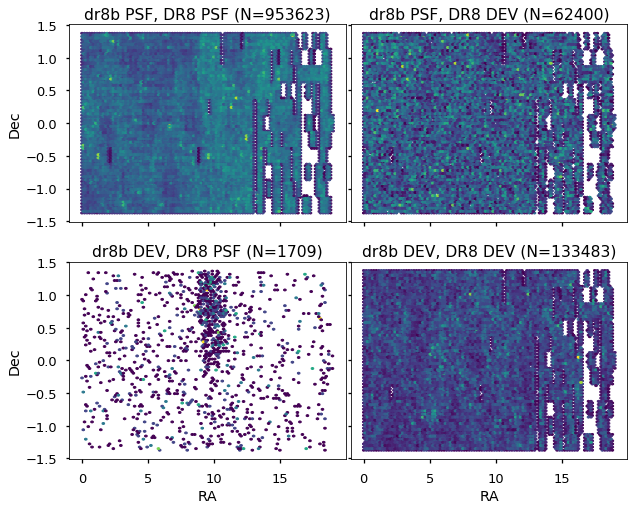

In [140]:
qa_radec_devpsf2()

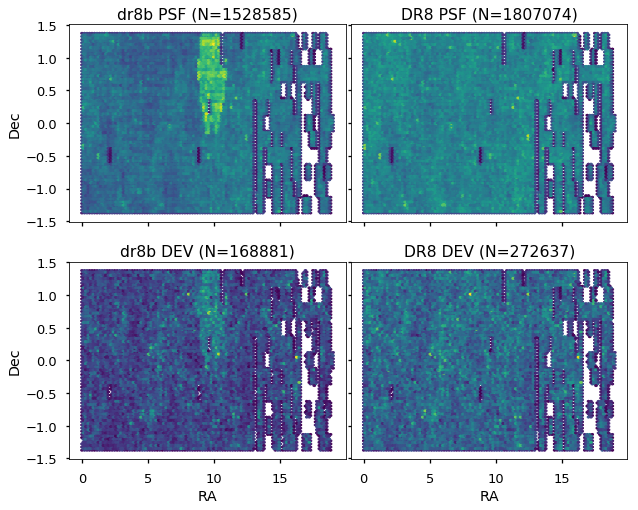

In [98]:
qa_radec_devpsf()

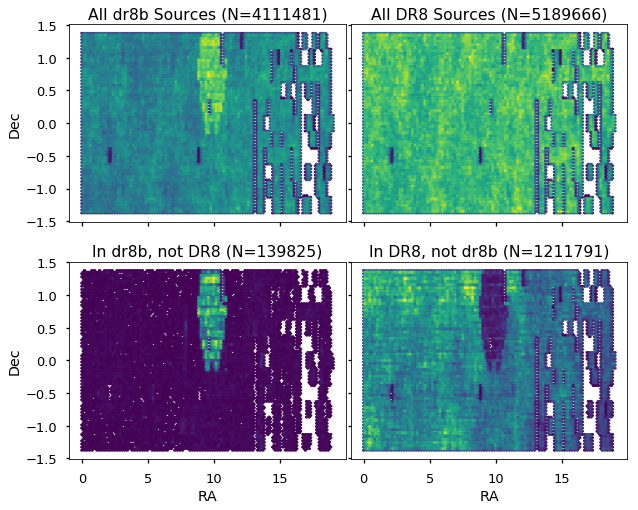

In [99]:
qa_radec_all()

/global/common/software/desi/cori/desiconda/20190311-1.2.7-img/conda/lib/python3.6/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in true_divide


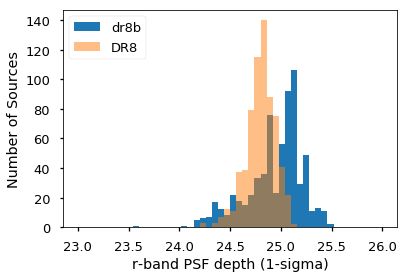

In [171]:
dr8_psf_dr8b_dev_cut = np.where((dr8_match['type'] == 'PSF ') * (dr8b_match['type'] == 'DEV ') * 
                                (dr8_match['ra'] > 7) * (dr8_match['ra'] < 12) * 
                                (dr8_match['dec'] > 0))[0]
dr88 = dr8_match[dr8_psf_dr8b_dev_cut]
drbb = dr8b_match[dr8_psf_dr8b_dev_cut]
#print(np.max(dr88['nobs_z']), np.max(drbb['nobs_z']))
#plt.hexbin(22.5-2.5*np.log10(drbb['galdepth_r']), -2.5 * np.log10(dr88['flux_r']/drbb['flux_r']), mincnt=1)
#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
#_ = ax1.hist2d(drbb['ra'], drbb['dec'], weights=drbb['psfdepth_r'], bins=25)
#_ = ax2.hist2d(dr88['ra'], dr88['dec'], weights=dr88['psfdepth_r'], bins=25)
_ = plt.hist(22.5-2.5*np.log10(5/np.sqrt(drbb['psfdepth_r'])), bins=50, range=(23, 26), label='dr8b')
_ = plt.hist(22.5-2.5*np.log10(5/np.sqrt(dr88['psfdepth_r'])), bins=50, range=(23, 26), alpha=0.5, label='DR8')
plt.xlabel('r-band PSF depth (1-sigma)')
plt.ylabel('Number of Sources')
plt.legend(loc='upper left')
#plt.colorbar(im)
#ax.hexbin(drbb['nobs_r'], drbb['psfdepth_r']/dr88['psfdepth_r'], mincnt=1)
#ax.hexbin(22.5-2.5*np.log10(drbb['flux_r']), drbb['psfdepth_r']/dr88['psfdepth_r'], mincnt=1)
#ax.set_xlim(2, 4)
#ax.set_ylim(2, 4)

In [136]:
print(len(drbb))

8888


In [135]:
def get_cutouts(cat, nperrow=5, dr='dr7', zoom='15'): 
    baseurl = 'http://legacysurvey.org//viewer-dev/'
        
    nrow = np.ceil(len(cat) / nperrow).astype('int')
    jpgsplit = list()
    for ii in range(nrow):
        i1 = nperrow*ii
        i2 = nperrow*(ii+1)
        if i2 > len(cat):
            i2 = len(cat)
        jpgsplit.append(cat[i1:i2])
    #print('Splitting the sample into {} rows with {} mosaics per row.'.format(nrow, nperrow))
    
    fig, ax = plt.subplots(nrow, nperrow, figsize=(3*nperrow, 3*nrow))
    
    ii = 0
    for jj, jpgrow in enumerate(jpgsplit):
        print('Row {}:'.format(jj+1))
        for obj in jpgrow:
            thisax = ax.flat[ii]
            url = '{}jpeg-cutout?ra={:.9f}1&dec={:.8f}&zoom={}&layer=decals-{}-model'.format(
                baseurl, obj['ra'], obj['dec'], zoom, dr.lower())
            print('{}?ra={:.9f}1&dec={:.8f}&zoom={}&layer=decals-{}-model'.format(
                baseurl, obj['ra'], obj['dec'], zoom, dr.lower()))
            #print(url)
            
            img = skimage.io.imread(url)
            thisax.imshow(img)
            thisax.axis('off')
            ii += 1
        print()

In [ ]:
get_cutouts(exp_needles_dr7[:25], dr='DR7')

### Get the fraction of morphological type for each target type as a function of magnitude.¶

In [82]:
def maghist_bins(deltam=0.5, minmag=14, maxmag=24, binedges=False):
    """Magnitude bins."""
    if binedges:
        bins = np.arange(minmag, maxmag, deltam) # bin left edges
    else:
        bins = np.arange(minmag, maxmag, deltam) + deltam / 2 # bin centers
    return bins

In [83]:
def maghist_type(data):
    """Fraction of a given morphological types as a function of magnitude."""
    bins = maghist_bins(binedges=True)
    hist, _ = np.histogram( data, bins=len(bins), range=(bins.min(), bins.max()) )
    return hist

In [88]:
def qa_maghist(data, dr=None, ax=None):
    """Simple QA plot."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
        
    magbins = data['MAG']
    ls = iter(['-', '--', '-.', ':', '-'])
    marker = iter(['s', 'o', '^', 'D', 'p'])
    
    for morph in ('PSF', 'REX', 'EXP', 'DEV', 'COMP'):
        if morph in data.colnames:
            good = data[morph] > 0
            ax.plot(magbins[good], data[morph][good], '{}{}'.format(next(ls), next(marker)),
                    label=morph, lw=2, markersize=10)#, ls=next(ls)
    ax.set_ylim(0, 1)
    ax.set_ylabel('Morphological Type Fraction')
    ax.set_xlabel('$r$ (AB mag)')
    if dr:
        ax.set_title(dr)
        #ax.text(0.1, 0.95, dr, ha='left', va='top', 
        #        transform=ax.transAxes, fontsize=18)
    ax.legend(loc='upper right')

In [85]:
def maghist_normalize(maghist):
    """Normalize the type fractions and write out."""
    morph = [mm.strip() for mm in maghist.keys()]
    typefrac = [maghist[mm] for mm in maghist.keys()]

    frac = np.vstack(typefrac).astype('f4')
    tot = np.sum(frac, axis=0)
    normfrac = np.zeros_like(frac)
    notzero = np.where( tot > 0 )[0]
    for ii in range(frac.shape[0]):
        normfrac[ii, notzero] = frac[ii, notzero] / tot[notzero]
    
    out = Table()
    #out.add_column(Column(name='MORPH', data=morph))
    out.add_column(Column(name='MAG', data=maghist_bins(), dtype='f4'))
    for ii, mm in enumerate(morph):
        out.add_column(Column(name=mm, data=normfrac[ii, :], dtype='f4'))
                         
    return out

In [86]:
def get_maghist(cat, dr=None, ax=None):
    """Get the magnitude histogram of each morphological type."""
    maghist = dict()
    for morph in ('PSF ', 'REX ', 'EXP ', 'DEV ', 'COMP'):
        indx = (cat['type'] == morph) * (cat['flux_r'] > 0)
        rmag = 22.5 - 2.5 * np.log10(cat['flux_r'][indx])
        maghist[morph.strip()] = maghist_type(rmag)
    out = maghist_normalize(maghist)
    qa_maghist(out, dr=dr, ax=ax)
    return out

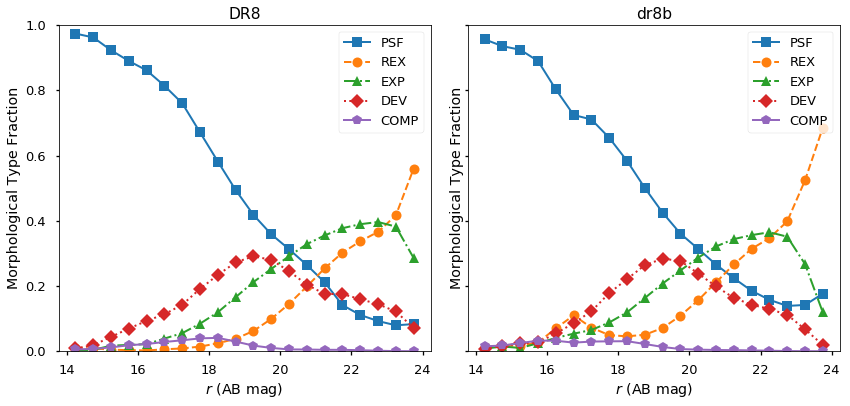

In [89]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
_ = get_maghist(dr8, dr='DR8', ax=ax1)
_ = get_maghist(dr8b, dr='dr8b', ax=ax2)
plt.subplots_adjust(wspace=0.1)

In [ ]:
stop

In [11]:
def write_viewer_file(cat, objtype='EXP', dr='DR7'):
    outfile = os.path.join(os.getenv('HOME'), 'needles-{}-{}.fits'.format(objtype.lower(), dr.lower()))
    out = Table()
    out['ra'] = cat['ra']
    out['dec'] = cat['dec']
    out['name'] = cat['objid']
    print('Writing {}'.format(outfile))
    out.write(outfile, format='fits', overwrite=True)

In [12]:
def get_ba_radius_rmag(cat, objtype='EXP'):
    if objtype == 'EXP':
        radius = cat['shapeexp_r'].data
        e1, e2 = cat['shapeexp_e1'].data, cat['shapeexp_e2'].data
    elif objtype == 'DEV':
        radius = cat['shapedev_r'].data
        e1, e2 = cat['shapedev_e1'].data, cat['shapedev_e2'].data
    else:
        raise NotImplementedError
        
    ell = np.hypot(e1, e2).squeeze()
    ba = (1 - ell) / (1 + ell) 
    rmag = 22.5 - 2.5 * np.log10(cat['flux_r'].data)
    
    # surface brightness
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        sb = rmag + 2.5 * np.log10( np.pi * radius**2 )
    
    return ba, radius, rmag, sb

In [13]:
def get_needles(cat, objtype='EXP', dr='DR7', ba_cut=0.1, radius_cut=25):

    if objtype == 'EXP':
        these = (cat['type'] == 'EXP ') * (cat['flux_r'] > 0)
        if dr == 'DR7':
            these = these * (cat['brightstarinblob'] == 0)
    elif objtype == 'DEV':
        these = (cat['type'] == 'DEV ') * (cat['flux_r'] > 0)
        if dr == 'DR7':
            these = these * (cat['brightstarinblob'] == 0)
    else:
        raise NotImplementedError
            
    ba, radius, rmag, sb = get_ba_radius_rmag(cat[these], objtype=objtype)

    indx = np.where( (ba < ba_cut) * (radius > radius_cut) )[0]
    needles = cat[these][indx]

    print('Found {} {} needles in {} with b/a<{:.2f} and radius>{:d} arcsec.'.format(
        len(needles), objtype, dr, ba_cut, radius_cut))

    write_viewer_file(needles, objtype=objtype, dr=dr)
    
    qa_needles(cat[these], needles, objtype=objtype, dr=dr)
    
    return needles, ba[indx], radius[indx], rmag[indx], sb[indx]

In [14]:
def qa_needles(cat, needles, objtype='EXP', dr='DR7'):
    """Try to identify needles based on their size and ellipticity (or b/a ratio).
    
    """
    ba, radius, rmag, sb = get_ba_radius_rmag(cat, objtype=objtype)
    ba_needles, radius_needles, rmag_needles, sb_needles = get_ba_radius_rmag(needles, objtype=objtype)
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 3))
    
    ax1.scatter(rmag, ba, s=3, label=objtype, alpha=0.5)
    ax1.scatter(rmag_needles, ba_needles, s=15, label=objtype, alpha=0.5)

    ax2.scatter(radius, ba, s=3, label=objtype, alpha=0.5)
    ax2.scatter(radius_needles, ba_needles, s=15, label=objtype, alpha=0.5)
    
    ax3.scatter(rmag, radius, s=3, label=objtype, alpha=0.5)
    ax3.scatter(rmag_needles, radius_needles, s=15, label=objtype, alpha=0.5)
        
    ax4.scatter(rmag, sb, s=3, label=objtype, alpha=0.5)
    ax4.scatter(rmag_needles, sb_needles, s=15, label=objtype, alpha=0.5)
        
    ax1.set_xlabel('r (AB mag)')
    ax1.set_ylabel('Minor-to-Major Axis Ratio)')
    
    ax2.set_xlabel('Half-light Radius (arcsec)')
    ax2.set_ylabel('Minor-to-Major Axis Ratio)')

    ax3.set_xlabel('r (AB mag)')
    ax3.set_ylabel('Half-light Radius (arcsec)')
    
    ax4.set_xlabel('r (AB mag)')
    ax4.set_ylabel(r'$\mu$ (mag / arcsec$^{2}$)')
    
    ax1.set_xlim(14, 26)
    ax1.set_ylim(0, 1)

    ax2.set_xlim(0, 155)
    ax2.set_ylim(0, 1)
    
    ax3.set_xlim(14, 26)
    ax3.set_ylim(0, 155)
    
    ax4.set_xlim(14, 26)
    ax4.set_ylim(35, 15)
    
    fig.suptitle('{}: Type = {}'.format(dr, objtype), fontsize=16)
    fig.subplots_adjust(wspace=0.4)

Found 177 DEV needles in DR7 with b/a<0.10 and radius>25 arcsec.
Writing /global/homes/i/ioannis/needles-dev-dr7.fits


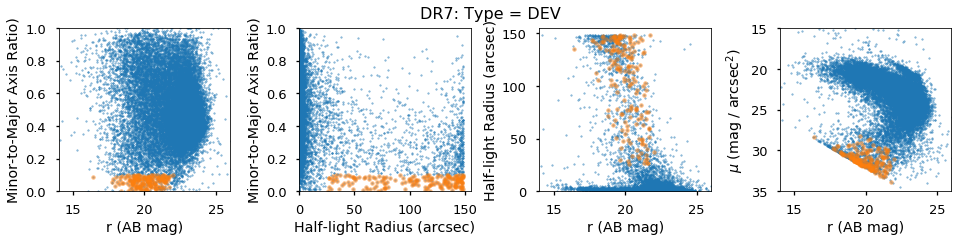

In [15]:
dev_needles_dr7, dev_needles_ba_dr7, dev_needles_radius_dr7, dev_needles_rmag_dr7, dev_sb_dr7 = get_needles(
    dr7, objtype='DEV', dr='DR7')

Found 101 DEV needles in DR5 with b/a<0.10 and radius>25 arcsec.
Writing /global/homes/i/ioannis/needles-dev-dr5.fits


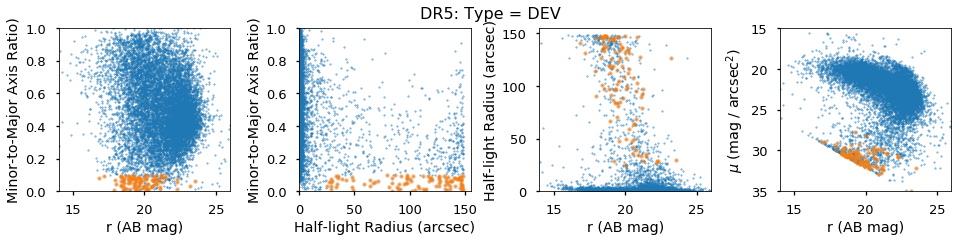

In [16]:
dev_needles_dr5, dev_needles_ba_dr5, dev_needles_radius_dr5, dev_needles_rmag_dr5, dev_needles_sb_dr5 = get_needles(
    dr5, objtype='DEV', dr='DR5')

Found 38 EXP needles in DR7 with b/a<0.10 and radius>25 arcsec.
Writing /global/homes/i/ioannis/needles-exp-dr7.fits


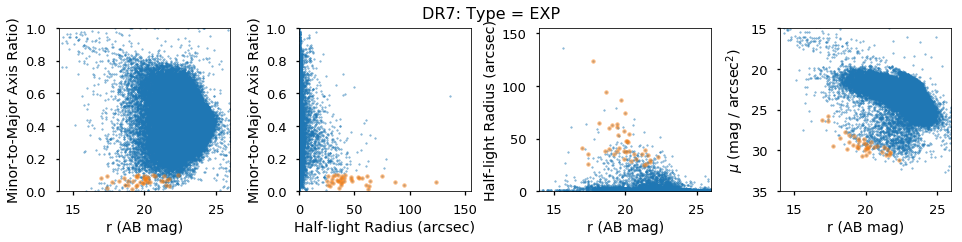

In [17]:
exp_needles_dr7, exp_needles_ba_dr7, exp_needles_radius_dr7, exp_needles_rmag_dr7, exp_needles_sb_dr7 = get_needles(
    dr7, objtype='EXP', dr='DR7')

Found 20 EXP needles in DR5 with b/a<0.10 and radius>25 arcsec.
Writing /global/homes/i/ioannis/needles-exp-dr5.fits


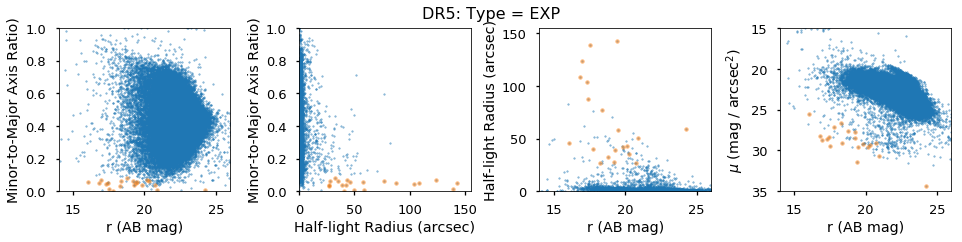

In [18]:
exp_needles_dr5, exp_needles_ba_dr5, exp_needles_radius_dr5, exp_needles_rmag_dr5, exp_needles_sb_dr5 = get_needles(
    dr5, objtype='EXP', dr='DR5')

Row 1:
http://legacysurvey.org//viewer-dev/?ra=15.0953819751&dec=2.40427336&zoom=15&layer=decals-dr7-model
http://legacysurvey.org//viewer-dev/?ra=15.0126772721&dec=2.62215105&zoom=15&layer=decals-dr7-model
http://legacysurvey.org//viewer-dev/?ra=15.5126289751&dec=-0.36176636&zoom=15&layer=decals-dr7-model
http://legacysurvey.org//viewer-dev/?ra=15.5943969301&dec=-0.21477382&zoom=15&layer=decals-dr7-model
http://legacysurvey.org//viewer-dev/?ra=15.6745234851&dec=-0.14119022&zoom=15&layer=decals-dr7-model

Row 2:
http://legacysurvey.org//viewer-dev/?ra=15.5220826961&dec=-0.14383274&zoom=15&layer=decals-dr7-model
http://legacysurvey.org//viewer-dev/?ra=15.6657802841&dec=-0.13492690&zoom=15&layer=decals-dr7-model
http://legacysurvey.org//viewer-dev/?ra=15.2731663631&dec=2.03317682&zoom=15&layer=decals-dr7-model
http://legacysurvey.org//viewer-dev/?ra=15.2733147641&dec=2.03312811&zoom=15&layer=decals-dr7-model
http://legacysurvey.org//viewer-dev/?ra=15.2363234591&dec=1.15222280&zoom=15&lay

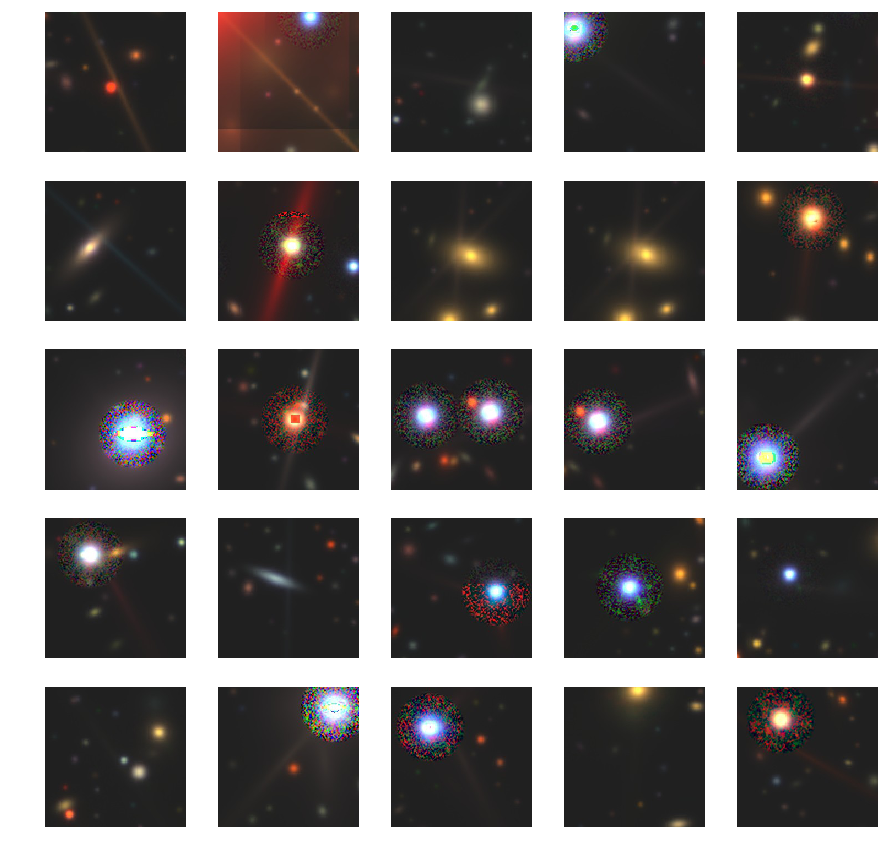

In [20]:
get_cutouts(dev_needles_dr7[:25], dr='DR7')

Row 1:
http://legacysurvey.org//viewer-dev/?ra=15.0739138071&dec=2.49687836&zoom=15&layer=decals-dr7-model
http://legacysurvey.org//viewer-dev/?ra=15.0339492911&dec=2.62163441&zoom=15&layer=decals-dr7-model
http://legacysurvey.org//viewer-dev/?ra=15.0336895921&dec=2.62250045&zoom=15&layer=decals-dr7-model
http://legacysurvey.org//viewer-dev/?ra=15.4565225951&dec=1.99841179&zoom=15&layer=decals-dr7-model
http://legacysurvey.org//viewer-dev/?ra=15.3052022881&dec=-0.69427240&zoom=15&layer=decals-dr7-model

Row 2:
http://legacysurvey.org//viewer-dev/?ra=15.2939785141&dec=-0.68344276&zoom=15&layer=decals-dr7-model
http://legacysurvey.org//viewer-dev/?ra=15.6762859021&dec=3.07950780&zoom=15&layer=decals-dr7-model
http://legacysurvey.org//viewer-dev/?ra=15.0456132011&dec=0.90396842&zoom=15&layer=decals-dr7-model
http://legacysurvey.org//viewer-dev/?ra=15.1148252111&dec=0.98449223&zoom=15&layer=decals-dr7-model
http://legacysurvey.org//viewer-dev/?ra=15.0541375981&dec=1.09951502&zoom=15&layer=

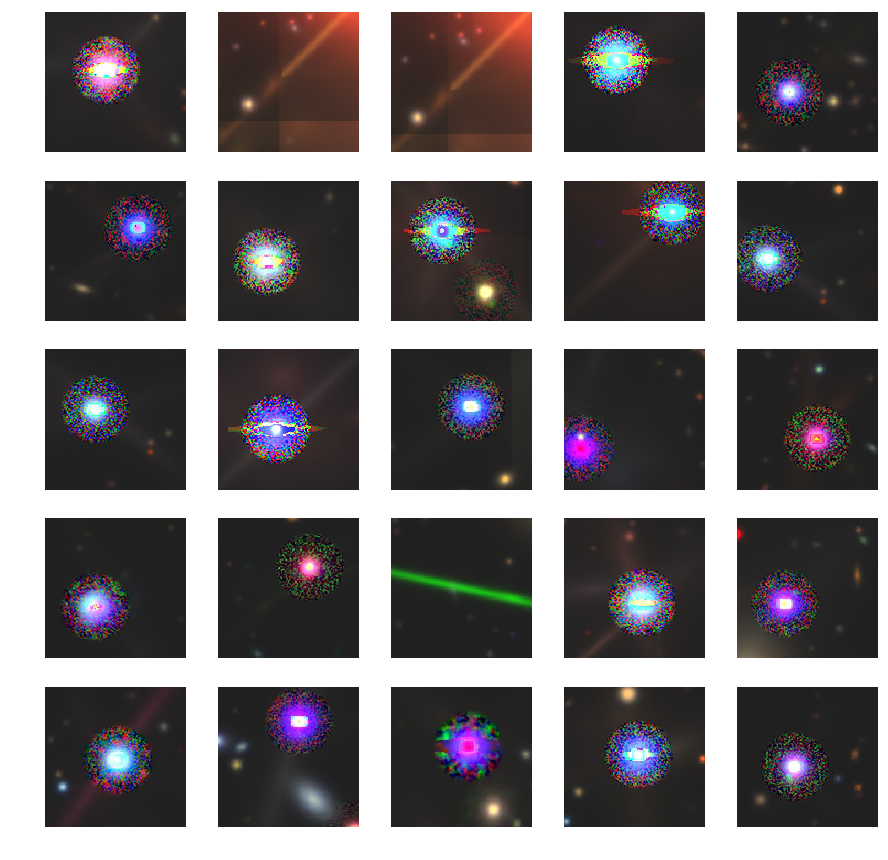

In [22]:
get_cutouts(exp_needles_dr7[:25], dr='DR7')

### Study large galaxies

In [23]:
def qa_largegals(cat, largegals, objtype='EXP', dr='DR7'):
    """Try to identify needles based on their size and ellipticity (or b/a ratio).
    
    """
    ba, radius, rmag, sb = get_ba_radius_rmag(cat, objtype=objtype)
    ba_largegals, radius_largegals, rmag_largegals, sb_largegals = get_ba_radius_rmag(largegals, objtype=objtype)
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 3))
    
    ax1.scatter(rmag, ba, s=3, label=objtype, alpha=0.5)
    ax1.scatter(rmag_largegals, ba_largegals, s=15, label=objtype, alpha=0.5)

    ax2.scatter(radius, ba, s=3, label=objtype, alpha=0.5)
    ax2.scatter(radius_largegals, ba_largegals, s=15, label=objtype, alpha=0.5)
    
    ax3.scatter(rmag, radius, s=3, label=objtype, alpha=0.5)
    ax3.scatter(rmag_largegals, radius_largegals, s=15, label=objtype, alpha=0.5)

    ax4.scatter(rmag, sb, s=3, label=objtype, alpha=0.5)
    ax4.scatter(rmag_largegals, sb_largegals, s=15, label=objtype, alpha=0.5)
    
    ax1.set_xlabel('r (AB mag)')
    ax1.set_ylabel('Minor-to-Major Axis Ratio)')
    
    ax2.set_xlabel('Half-light Radius (arcsec)')
    ax2.set_ylabel('Minor-to-Major Axis Ratio)')

    ax3.set_xlabel('r (AB mag)')
    ax3.set_ylabel('Half-light Radius (arcsec)')

    ax4.set_xlabel('r (AB mag)')
    ax4.set_ylabel(r'$\mu$ (mag / arcsec$^{2}$)')
    
    ax1.set_xlim(14, 26)
    ax1.set_ylim(0, 1)

    ax2.set_xlim(0, 155)
    ax2.set_ylim(0, 1)
    
    ax3.set_xlim(14, 26)
    ax3.set_ylim(0, 155)

    ax4.set_xlim(14, 26)
    ax4.set_ylim(35, 15)
    
    fig.suptitle('{}: Type = {}'.format(dr, objtype), fontsize=16)
    fig.subplots_adjust(wspace=0.3)

In [24]:
def get_largegals(cat, objtype='EXP', dr='DR7', radius_cut=60, radius_max=150):

    if objtype == 'EXP':
        these = (cat['type'] == 'EXP ') * (cat['flux_r'] > 0)
        if dr == 'DR7':
            these = these * (cat['brightstarinblob'] == 0)
    elif objtype == 'DEV':
        these = (cat['type'] == 'DEV ') * (cat['flux_r'] > 0)
        if dr == 'DR7':
            these = these * (cat['brightstarinblob'] == 0)
    else:
        raise NotImplementedError
            
    ba, radius, rmag, sb = get_ba_radius_rmag(cat[these], objtype=objtype)

    indx = np.where( (radius > radius_cut) * (radius < radius_max) )[0]
    largegals = cat[these][indx]

    print('Found {} {} large galaxies in {} with radius>{:d} arcsec.'.format(
        len(largegals), objtype, dr, radius_cut))

    qa_largegals(cat[these], largegals, objtype=objtype, dr=dr)
    
    return largegals, radius[indx], rmag[indx], sb[indx]

Found 982 DEV large galaxies in DR7 with radius>60 arcsec.


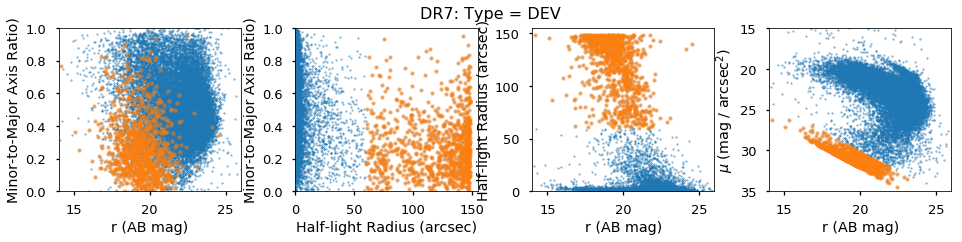

In [25]:
dev_largegals, dev_largegals_radius, dev_largegals_rmag, dev_largegals_sb = get_largegals(
    dr7, objtype='DEV', dr='DR7')

In [27]:
srt = np.argsort(dev_largegals_radius)[::-1]
print(dev_largegals_radius[srt[:25]])

[ 148.40159607  148.3951416   148.38980103  148.36270142  148.35852051
  148.32618713  148.31904602  148.31819153  148.30189514  148.29936218
  148.27709961  148.27062988  148.26235962  148.25468445  148.24615479
  148.23269653  148.16340637  148.15951538  148.15518188  148.15350342
  148.1526947   148.15194702  148.09544373  148.07525635  148.06214905]


Row 1:
http://legacysurvey.org//viewer-dev/?ra=15.1302048931&dec=-1.68950792&zoom=14&layer=decals-dr7-model
http://legacysurvey.org//viewer-dev/?ra=15.1095115251&dec=2.25254808&zoom=14&layer=decals-dr7-model
http://legacysurvey.org//viewer-dev/?ra=15.3284880061&dec=-0.89373271&zoom=14&layer=decals-dr7-model
http://legacysurvey.org//viewer-dev/?ra=15.0732722091&dec=-1.34655432&zoom=14&layer=decals-dr7-model
http://legacysurvey.org//viewer-dev/?ra=15.1202901181&dec=-0.65861400&zoom=14&layer=decals-dr7-model

Row 2:
http://legacysurvey.org//viewer-dev/?ra=15.5446610421&dec=2.32332340&zoom=14&layer=decals-dr7-model
http://legacysurvey.org//viewer-dev/?ra=15.7257159231&dec=-0.53364862&zoom=14&layer=decals-dr7-model
http://legacysurvey.org//viewer-dev/?ra=15.2068335861&dec=2.04052718&zoom=14&layer=decals-dr7-model
http://legacysurvey.org//viewer-dev/?ra=15.0106107581&dec=0.89087633&zoom=14&layer=decals-dr7-model
http://legacysurvey.org//viewer-dev/?ra=15.5612284081&dec=1.57237557&zoom=14&lay

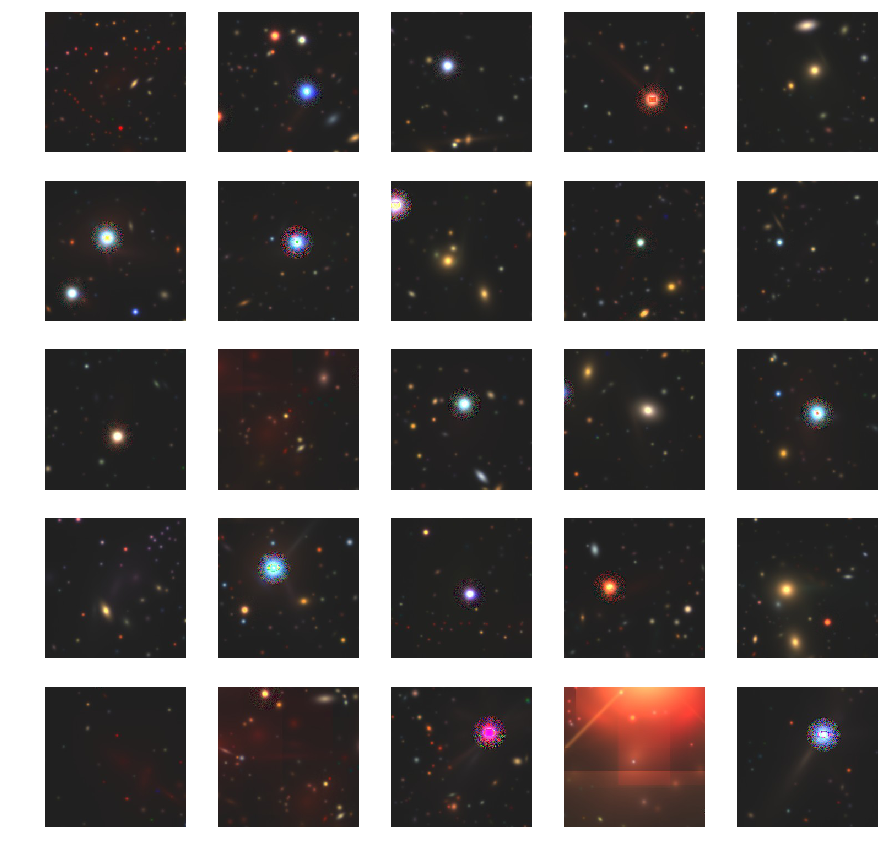

In [29]:
get_cutouts(dev_largegals[srt[:25]], dr='DR7', zoom='14')